In [62]:
import pandas as pd
import seaborn as sns

from typing import List
from IPython.display import display

In [3]:
def read_data_from_csv(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path)

In [4]:
HOTEL_BOOKINGS_DATASET_PATH = './datasets/hotel_bookings.csv'
hotel_bookings_df = read_data_from_csv(file_path=HOTEL_BOOKINGS_DATASET_PATH)

In [5]:
hotel_bookings_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


# Información sobre el dataset

## Atributos

| Variable  | Tipo de Variable  |  Descripción  |
|---|---|---|
| hotel  | Variable Cualitativa - Texto - Nominal  | Nombre del hotel  |
|  is_canceled | Variable Cualitativa - Texto - Nominal  |  Valor que indica si la reserva fue cancelada  |
|  lead_time | Variable Cuantitativa - Número - Discreta  | Cantidad de dias entre la reserva y la llegada al hotel  |
|  arrival_date_year | Variable Cuantitativa - Número - Discreta ? |  Año de arrivo |
| arrival_date_month  | Variable Cualitativa - Texto - Nominal ? |  Mes del arrivo |
| arrival_date_week_number  | Variable Cuantitativa - Número - Discreta ?  | Número de la semana del arrivo  |
|  arrival_date_day_of_month | Variable Cuantitativa - Número - Discreta ? | Día del mes del arrivo  |
|  stays_in_weekend_nights  | Variable Cuantitativa - Número - Discreta  |  Días del fin de semana (Sabado - Domingo) que abarca la reserva |
|  stays_in_week_nigths | Variable Cuantitativa - Número - Discreta  | Días de la semana (Lunes a Viernes) que abarca la reserva  |
|  adults | Variable Cuantitativa - Número - Discreta  | Cantidad de adultos  |
|  children | Variable Cuantitativa - Número - Discreta (En el Dataset aparece como continua)  |  Cantidad de niños. Cabe aclarar que los datos provenientes del dataset tiene tipo float y se debe transformar, ya que una reserva no puede tener 1.3 niños  |
| babies  | Variable Cuantitativa - Número - Discreta  | Cantidad de bebes  |
|  meal | Variable Cualitativa - Texto - Nominal  |  Tipo de comida reservada (Detalles en Categorias) |
|  country | Variable Cualitativa - Texto - Nominal  |  Pais de origen  |
| market_segment  | Variable Cualitativa - Texto - Nominal  | Segmento del mercado asignado (Detalles en Categorias)  |
| distribution_channel  |   |   |
|  is_repeated_guest | Variable Cualitativa - Número - Nominal  | Si el huesped ya se hospedo en el hotel  |
|  previous_cancelations |  Variable Cuantitativa - Número - Discreta |  Cantidad de cancelaciones  |
|  previous_bookings_not_canceled |  Variable Cuantitativa - Número - Discreta |  Cantidad de veces que no cancelo la reserva  |
| reserved_room_type  | Variable Cualitativa - Text - Nominal  | Código del tipo de cuarto reservado  |
| booking_changes  |  Variable Cuantitativa - Número - Discreta |  Cantidad de cambios en la reserva desde la fecha de reserva hasta la cancelación o check-in  |
| deposit_types  | Variable Cualitativa - Texto - Discreta  | Tipo de depósito que se hizo (Detalles en Categorias)   |
| agent  | Variable Cualitativa - Número - Nominal  | ID de la agencia que hizo la reserva   |
| company  |  Varaible Cualitativa - Número - Nominal | ID de la compania que hizo la reserva  |
| days_in_waiting_list  |  Variable Cuantitativa - Número - Discreta | Número de días que la reserva estuvo en lista de espera hasta ser confirmada  |
| customer_type  |  Variable Cualitativa - Texto - Nominal |  Tipo de reserva (Detalles en Categorias) |
|  adr |   |   |
|  required_car_parking_spaces |  Variable Cuantitativa - Número - Discreta | Cantidad de espacios de estacionamiento para el huesped  |
| total_of_special_requests  |  Variable Cuantitativa - Número - Discreta | Cantidad de pedidos especiales que hizo el huesped  |
|  reservation_status |  Variable Cualitativa - Texto - Nominal | Estado de la reserva (Detalles en Categorias)  |
|  reservation_status_date | Variable Cuantitativa - Número - Continua  | Fecha de la ultima vez que se actualizo reservation_status  |


## Categorias
- Meal:
    - Undefined/SC : No meal package.
    - BB : Bed & Breakfast.
    - HB : Breakfast and one other meal.
    - FB : Breafast, lunch and dinner.
- Market Segment:
    - TA : Agencias de viaje.
    - TO : Operador turístico.
- Deposit Type:
    - No Deposit : No se hizo un deposito.
    - Non Refund : Un deposito se hizo para el valor total de la reseva.
    - Refundable: Un deposito se hizo para un valor menor al total de la reserva.
- Customer Type:
    - Contract : Cuando la reserva esta asociada a un contrato.
    - Group : Cuando la reserva esta asocidada a un grupo.
    - Transient : Cuando la reserva no esta asociada a un contrato ni a un grupo.
    - Transient-party : Cuando la reserva es del tipo transient pero esta asociada a otra reserva transient.
- Reservation Status:
    - Canceled : La reserva fue cancelada.
    - Check-Out : El cliente hizo el check-in y tambien el check-out.
    - No-Show : El cliente no hizo el check-in pero tampoco cancelo la reserva.

### Analizamos la frecuencia de cada categoria

In [16]:
def group_by_and_count_category(df: pd.DataFrame, column: str) -> pd.DataFrame:
    group_df = df.groupby([column])[column].count().reset_index(name='count')
    return group_df

def display_count_of_categories(df: pd.DataFrame, list_of_columns: List[str]):
    for categorical_column in list_of_columns:
        display(group_by_and_count_category(df=df, column=categorical_column))

In [17]:
list_of_category_columns = ['is_canceled', 'meal', 'market_segment', 'reserved_room_type', 'deposit_type', 'customer_type']
display_count_of_categories(df=hotel_bookings_df, list_of_columns=list_of_category_columns)

,is_canceled,count
0,0,75166
1,1,44224


,meal,count
0,BB,92310
1,FB,798
2,HB,14463
3,SC,10650
4,Undefined,1169


,market_segment,count
0,Aviation,237
1,Complementary,743
2,Corporate,5295
3,Direct,12606
4,Groups,19811
5,Offline TA/TO,24219
6,Online TA,56477
7,Undefined,2


,reserved_room_type,count
0,A,85994
1,B,1118
2,C,932
3,D,19201
4,E,6535
5,F,2897
6,G,2094
7,H,601
8,L,6
9,P,12


,deposit_type,count
0,No Deposit,104641
1,Non Refund,14587
2,Refundable,162


,customer_type,count
0,Contract,4076
1,Group,577
2,Transient,89613
3,Transient-Party,25124


### Analizamos la cantidad de registros vacios

In [22]:
display(hotel_bookings_df.isnull().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [36]:
def calculate_and_display_percentage_of_null_values(df: pd.DataFrame):
    number_of_rows = len(df)
    count_of_nulls: pd.Series = df.isnull().sum()

    for index, count in count_of_nulls.iteritems():
        if count != 0:
            print('{} percentage of nulls: {} - Total of nulls: {}'.format(index, (count / number_of_rows) * 100, count ))

In [37]:
calculate_and_display_percentage_of_null_values(hotel_bookings_df)

children percentage of nulls: 0.003350364352123293 - Total of nulls: 4
country percentage of nulls: 0.40874445095904177 - Total of nulls: 488
agent percentage of nulls: 13.686238378423655 - Total of nulls: 16340
company percentage of nulls: 94.30689337465449 - Total of nulls: 112593


Analizando la cantidad de nulos que tiene cada una de las columnas, podemos distinguir que la cantidad de nulos de las columnas 'children' y 'country' son estadisticamente despreciable. A estas filas nulas podemos eliminarlas, ya que perder un 0.4 % de la data no nos va a hacer perder demasiada información. A diferencia de las columnas mencionadas anteriormente, las columnas 'agent' y 'company' tienen un porcentaje más alto de nulos que no podemos ignorar. Vamos a seguir analizando la correlación que tienen ambas columnas con la columna a predecir (en este caso 'is_canceled') para observar que tanto peso tiene en nuestro modelo.

## Análisis de correlación

<AxesSubplot:>

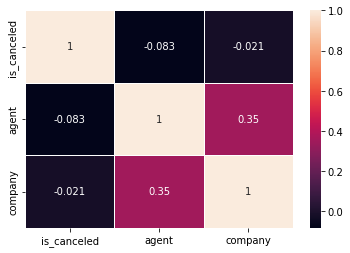

In [63]:
correlation_df = hotel_bookings_df[['is_canceled', 'agent', 'company']].corr()
sns.heatmap(correlation_df, linewidths=0.5, annot=True)

Como se ve en el Heathmap, la correlación que hay entre 'agent' y 'company' con 'is_canceled' es casi nula. Entonces, ya que estas columnas no tienen una correlación significante con la columna a predecir, decidimos dropearlas

## Variables con más correlación con 'is_canceled'

In [105]:
def get_biggest_correlations_for_column(df: pd.DataFrame, column: str, max_elements: int) -> pd.DataFrame:
    corr_df = df.corr()[column].sort_values(ascending=False)
    corr_df = corr_df.iloc[1:max_elements]
    corr_df.name = f'{column}_corr'

    return corr_df

In [109]:
correlation_series = get_biggest_correlations_for_column(df=hotel_bookings_df, column='is_canceled', max_elements=5)
correlation_series

lead_time                 0.293123
previous_cancellations    0.110133
adults                    0.060017
days_in_waiting_list      0.054186
Name: is_canceled_corr, dtype: float64

In [110]:
def display_scatter_plot(df: pd.DataFrame, x_column : str, y_column: str):
    df.plot.scatter(x=x_column, y=y_column)

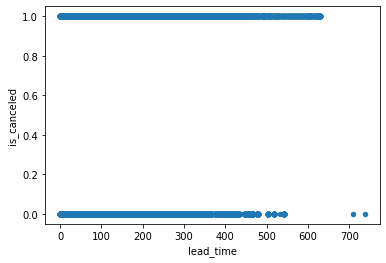

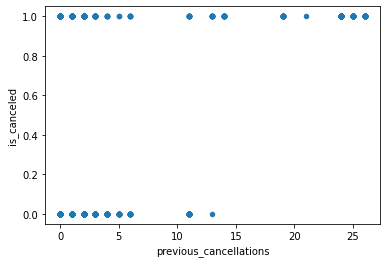

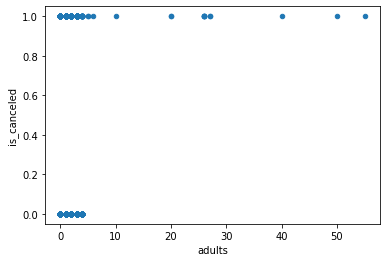

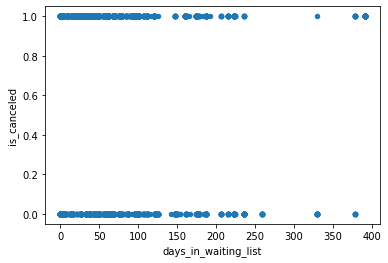

In [111]:
for index, _ in correlation_series.iteritems():
    display_scatter_plot(df=hotel_bookings_df, x_column=index, y_column='is_canceled')